# Imports and helper methods

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import math
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import make_column_selector

In [2]:
# A class for boosted hybrid modelling
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        # YOUR CODE HERE: fit self.model_1
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            # YOUR CODE HERE: make predictions with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        # YOUR CODE HERE: compute residuals
        y_resid = y-y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # YOUR CODE HERE: fit self.model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid


    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()  # long to wide



In [3]:
# Create features and shift output
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def make_lags_transformer(n_lags):
    return FunctionTransformer(lambda x: make_lags(x, n_lags))

# Encode these as sine/cosine features to capture cyclical nature
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [4]:
# Methods for feature engineering
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [5]:
# Plotting helpers
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [6]:
class Data_Object():
    def __init__(self,X,y):
        #store X and Y
        self.X=X
        self.y=y
        
class Lag_Transformer(BaseEstimator, TransformerMixin):
    """
    Transformer class to calculate data lags 
    """
    def __init__(self,lag):
        self.lag=lag
        
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.copy()
        y_data=y.copy()
        target=X.target
        # Add Object atributes for debbuging
        self.data_in=X
        
        # Call transformation function
        X_data=make_lags(y_data,self.lag)
        X=pd.concat([X, X_data])
        # Add Object atributes for debbuging
        self.data_out=X
        return X

In [7]:
class ColumnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

# Preliminary Data Transforms

In [8]:
# Get data
kaituna_data = pd.read_csv('../input/kaitunadata/kaituna_data2019-01-01_2022-10-19.csv',parse_dates=["TimeStamp"])
kaituna_data["TimeStamp"] = pd.to_datetime(kaituna_data['TimeStamp'], utc=True)
kaituna_data = kaituna_data.set_index("TimeStamp")
kaituna_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33117 entries, 2019-01-01 00:00:00+00:00 to 2022-10-18 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LakeLevel  33116 non-null  float64
 1   FlowRate   33117 non-null  float64
 2   Gate1      33117 non-null  float64
 3   Gate2      33117 non-null  float64
 4   Gate3      33117 non-null  float64
 5   Rainfall   33117 non-null  float64
dtypes: float64(6)
memory usage: 1.8 MB


In [9]:
#Average gate level
kaituna_data["AverageGate"] = kaituna_data[["Gate1", "Gate2", "Gate3"]].mean(axis=1)

# Average gate, rounded to the nearest 100
rounding_level = 100
kaituna_data["AverageGateOrdinal"] = rounding_level * round(kaituna_data["AverageGate"] / rounding_level)

# Extract hour, day, month, year from TimeStamp
kaituna_data["Hour"] = kaituna_data.index.hour
kaituna_data["DayOfWeek"] = kaituna_data.index.day_of_week
kaituna_data["DayOfYear"] = kaituna_data.index.dayofyear
kaituna_data["Month"] = kaituna_data.index.month
kaituna_data["Year"] = kaituna_data.index.year

In [10]:
#Define categorical columns
categorical_cols = ['Hour', 'DayOfWeek', 'Month', 'Year', 'AverageGateOrdinal']
levels = []
for col in categorical_cols:
    kaituna_data[col] = kaituna_data[col].astype('int')

#Numerical columns
numerical_cols = ['FlowRate','AverageGate','Rainfall','LakeLevel']

# Data Exploration
Initial data exploration - sanity checks and determining suitable features/outputs

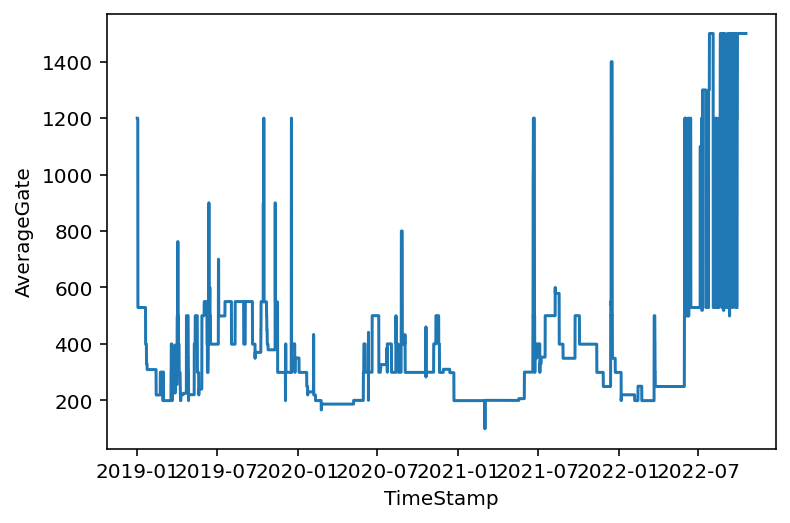

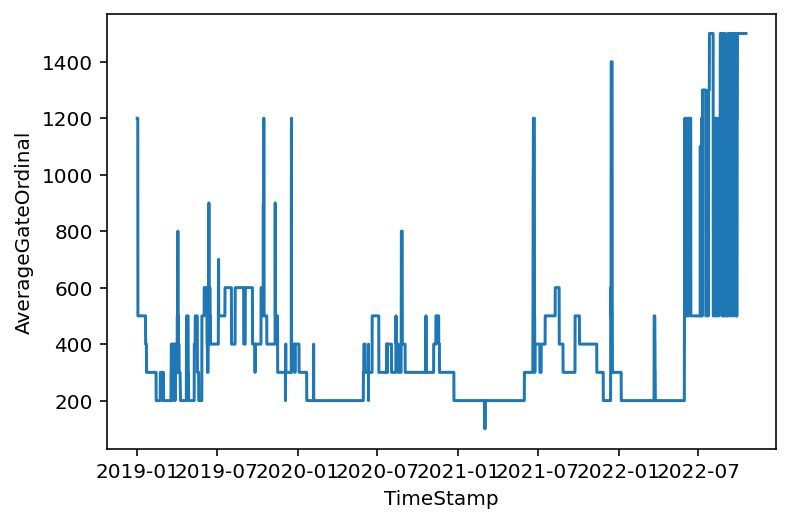

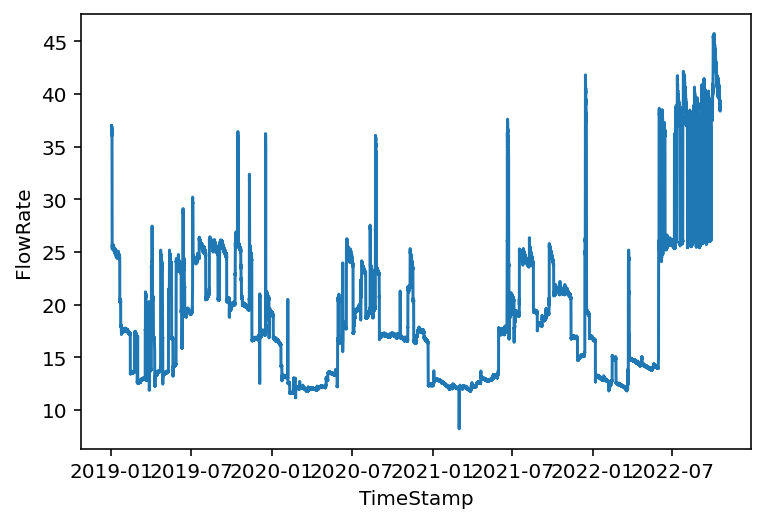

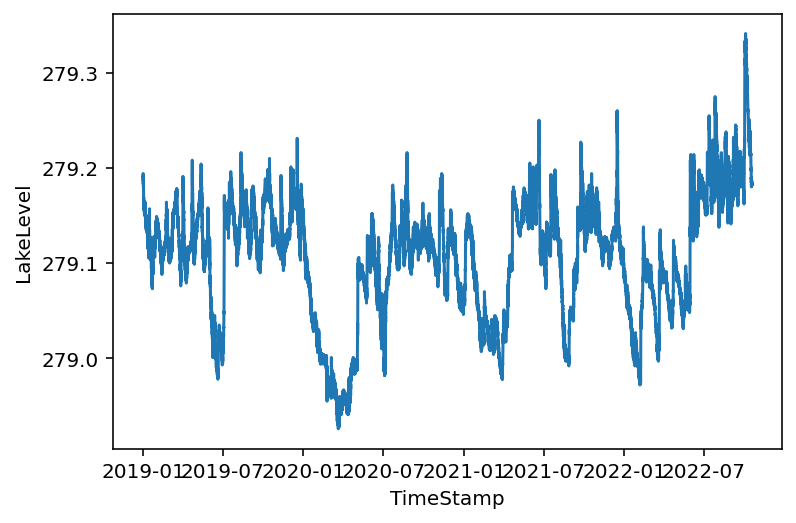

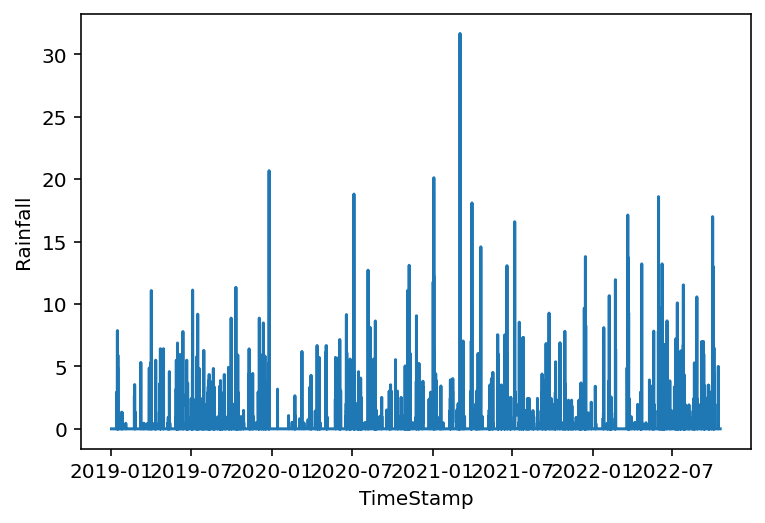

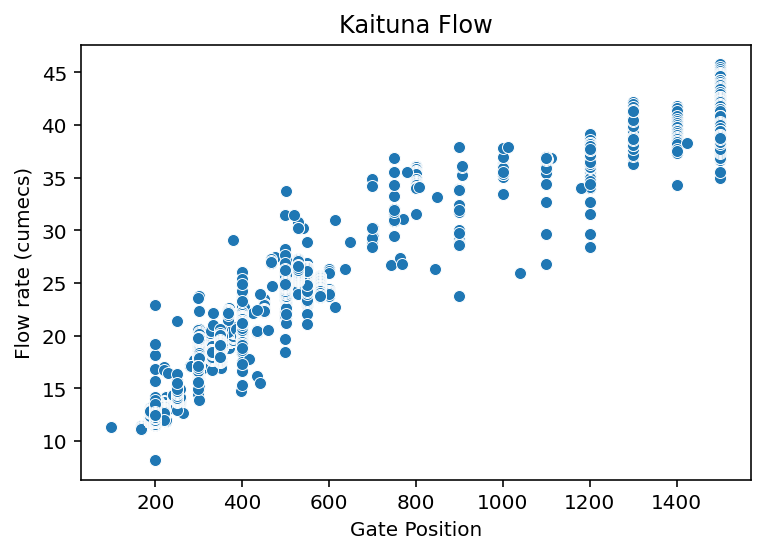

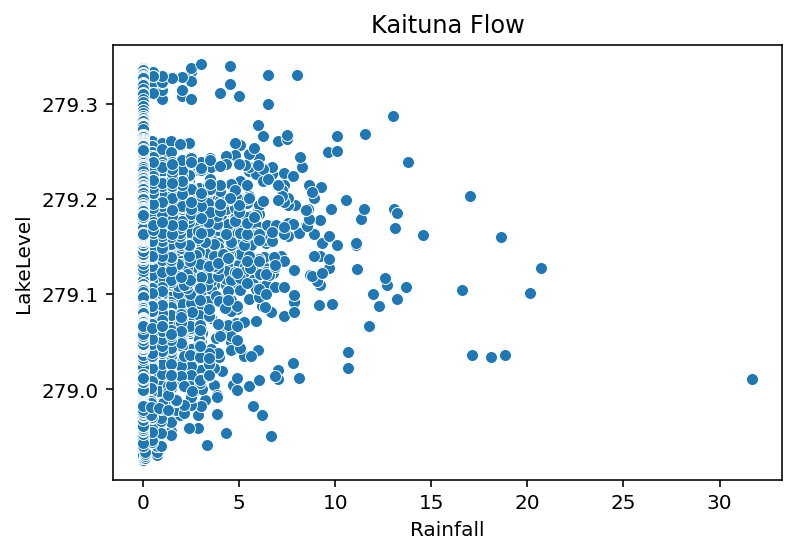

In [11]:
# Exploration of variables
sns.lineplot(x=kaituna_data.index,y=kaituna_data["AverageGate"])
plt.figure()
sns.lineplot(x=kaituna_data.index,y=kaituna_data["AverageGateOrdinal"])
plt.figure()
sns.lineplot(x=kaituna_data.index,y=kaituna_data["FlowRate"])
plt.figure()
sns.lineplot(x=kaituna_data.index,y=kaituna_data["LakeLevel"])
plt.figure()
sns.lineplot(x=kaituna_data.index,y=kaituna_data["Rainfall"])


# Visualise gate levels
plt.figure()
palette = ['tab:blue', 'tab:green', 'tab:red']
gates_to_cumecs = sns.scatterplot(
    x=kaituna_data["AverageGate"], 
    y=kaituna_data["FlowRate"], 
    #hue=kaituna_data["Year"],
    #palette='Set1'
    )
plt.ylabel('Flow rate (cumecs)')
plt.xlabel("Gate Position")
plt.title("Kaituna Flow")
plt.show()

# Investigate correlation of lake level and rainfall
plt.figure()
palette = ['tab:blue', 'tab:green', 'tab:red']
gates_to_cumecs = sns.scatterplot(
    x=kaituna_data["Rainfall"], 
    y=kaituna_data["LakeLevel"], 
    #hue=kaituna_data["Year"],
    #palette='Set1'
    )
plt.ylabel('LakeLevel')
plt.xlabel("Rainfall")
plt.title("Kaituna Flow")
plt.show()


In [12]:
# Shape
display(kaituna_data.shape)

# Describe
display(kaituna_data.describe())

# Describe ordinal variables
#print(kaituna_data[categorical_cols].describe())
display(kaituna_data.info())

(33117, 13)

,LakeLevel,FlowRate,Gate1,Gate2,Gate3,Rainfall,AverageGate,AverageGateOrdinal,Hour,DayOfWeek,DayOfYear,Month,Year
count,33116.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000,33117.000000
mean,279.105943,19.046455,386.385331,388.347223,397.773017,0.159982,390.835190,387.408280,11.498113,2.997252,175.516985,6.275870,2020.414802
std,0.064282,6.861799,302.063727,289.193999,291.413628,0.827929,279.872903,283.211295,6.925185,1.998631,102.529859,3.356175,1.088222
min,278.926000,8.222558,0.000000,0.000000,0.000000,0.000000,99.000000,100.000000,0.000000,0.000000,1.000000,1.000000,2019.000000
25%,279.067000,13.283541,219.000000,225.000000,230.000000,0.000000,219.666667,200.000000,5.000000,1.000000,87.000000,3.000000,2019.000000
50%,279.117000,17.269774,300.000000,299.000000,300.000000,0.000000,299.666667,300.000000,11.000000,3.000000,174.000000,6.000000,2020.000000
75%,279.151683,23.510011,500.000000,499.000000,499.000000,0.000000,499.000000,500.000000,18.000000,5.000000,261.000000,9.000000,2021.000000
max,279.341000,45.757437,1500.000000,1538.000000,1500.000000,31.678639,1500.000000,1500.000000,23.000000,6.000000,366.000000,12.000000,2022.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33117 entries, 2019-01-01 00:00:00+00:00 to 2022-10-18 00:00:00+00:00
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LakeLevel           33116 non-null  float64
 1   FlowRate            33117 non-null  float64
 2   Gate1               33117 non-null  float64
 3   Gate2               33117 non-null  float64
 4   Gate3               33117 non-null  float64
 5   Rainfall            33117 non-null  float64
 6   AverageGate         33117 non-null  float64
 7   AverageGateOrdinal  33117 non-null  int64  
 8   Hour                33117 non-null  int64  
 9   DayOfWeek           33117 non-null  int64  
 10  DayOfYear           33117 non-null  int64  
 11  Month               33117 non-null  int64  
 12  Year                33117 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 4.5 MB


None

# Observations
## Flow data and gate levels
This is highly seasonal. It appears that the primary trend is annual, peaking in winter and dipping in summer. However, it's not fully dependent on this, evidenced particularly by the latter months of 2022, where we had opens for several weeks.

## Rainfall
The rainfall data initially looked suspicious - 75% of data was 0mm. I checked and double checked the data loading process and it looks correct. It is possible that, because it is hourly data, that there are many more hours where it doesn't rain, compared to when it does rain.

## Case for predicting daily gate levels versus hourly
Given that so much rainfall data is actually 0, it may be preferable to try and predict the daily gate levels. This is actually favourable for a few reasons:

1. Paddlers typically understand this more than flow rates.
2. The gate levels, in my experience, rarely change in the course of a day/are set from the morning.

In saying this, if there is a gate change, say, in the afternoon, then it is possible that this will be missed by the algorithm. So let's begin with hourly and see how that goes

## Feature extraction

In [13]:
# Get features and target
# Date features
date_features = [
    #'Hour',
    'DayOfWeek',
    'Month'
]

#Numerical features
numerical_features = [
    'Rainfall',
    'LakeLevel',
    'FlowRate'
]

#Categorical features
categorical_features = [
    'AverageGateOrdinal'
]

#Combine to create the training data for the residuals model
X_raw = kaituna_data[date_features + numerical_features + categorical_features]

display(X_raw.shape)
display(X_raw.head())
display(X_raw.info())

(33117, 6)

,DayOfWeek,Month,Rainfall,LakeLevel,FlowRate,AverageGateOrdinal
TimeStamp,,,,,,
2019-01-01 00:00:00+00:00,1,1,0.0,279.192,36.970287,1200
2019-01-01 01:00:00+00:00,1,1,0.0,279.190,37.035728,1200
2019-01-01 02:00:00+00:00,1,1,0.0,279.194,36.741580,1200
2019-01-01 03:00:00+00:00,1,1,0.0,279.188,36.904889,1200
2019-01-01 04:00:00+00:00,1,1,0.0,279.187,36.904889,1200


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33117 entries, 2019-01-01 00:00:00+00:00 to 2022-10-18 00:00:00+00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DayOfWeek           33117 non-null  int64  
 1   Month               33117 non-null  int64  
 2   Rainfall            33117 non-null  float64
 3   LakeLevel           33116 non-null  float64
 4   FlowRate            33117 non-null  float64
 5   AverageGateOrdinal  33117 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 2.8 MB


None

### Summarising into daily 

Having initially tried hourly predictions, I quickly found two things:

1. Rainfall data was hard to use as it was mostly 0s
2. The number of timesteps predicting into the future were difficult to deal with and took a long time to train. 

Daily is perhaps more useful anyway, given how kayakers plan

In [14]:
X_daily = X_raw.groupby(by=X_raw.index.date).agg(
    Rainfall = ('Rainfall','sum'), 
    LakeLevel=('LakeLevel','mean'),
    DayOfWeek = ('DayOfWeek', 'mean'),
    Month = ('Month','mean'),
    AverageGateOrdinal = ('AverageGateOrdinal', lambda x:pd.Series.mode(x)[0]),
    FlowRate = ('FlowRate','mean')
)


X_daily.index = pd.to_datetime(X_daily.index)
X_daily.set_index(X_daily.index.to_period('D'), inplace=True)

display(X_daily.info())
display(X_daily.head())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1386 entries, 2019-01-01 to 2022-10-18
Freq: D
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rainfall            1386 non-null   float64
 1   LakeLevel           1386 non-null   float64
 2   DayOfWeek           1386 non-null   float64
 3   Month               1386 non-null   float64
 4   AverageGateOrdinal  1386 non-null   int64  
 5   FlowRate            1386 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 75.8 KB


None

,Rainfall,LakeLevel,DayOfWeek,Month,AverageGateOrdinal,FlowRate
2019-01-01,0.0,279.185500,1.0,1.0,1200,36.705079
2019-01-02,0.0,279.164083,2.0,1.0,500,28.952682
2019-01-03,0.0,279.158583,3.0,1.0,500,25.516551
2019-01-04,0.0,279.156375,4.0,1.0,500,25.482078
2019-01-05,0.0,279.159833,5.0,1.0,500,25.442862


### Sanity checks on daily summaries

In [15]:
# Shape
print(X_daily.shape)

# Describe
print(X_daily.describe())

# Describe ordinal variables
print(X_daily[categorical_features].describe())

(1386, 6)
          Rainfall    LakeLevel    DayOfWeek        Month  AverageGateOrdinal  \
count  1386.000000  1386.000000  1386.000000  1386.000000         1386.000000   
mean      3.822600   279.105908     2.997114     6.272727          380.880231   
std       9.897408     0.064054     2.000720     3.355572          273.027321   
min       0.000000   278.931125     0.000000     1.000000          200.000000   
25%       0.000000   279.066021     1.000000     3.000000          200.000000   
50%       0.000000   279.116875     3.000000     6.000000          300.000000   
75%       2.298005   279.150500     5.000000     9.000000          400.000000   
max     113.075382   279.332000     6.000000    12.000000         1500.000000   

          FlowRate  
count  1386.000000  
mean     19.050195  
std       6.800147  
min      11.623866  
25%      13.292445  
50%      17.303032  
75%      23.345346  
max      45.100496  
       AverageGateOrdinal
count         1386.000000
mean           380.

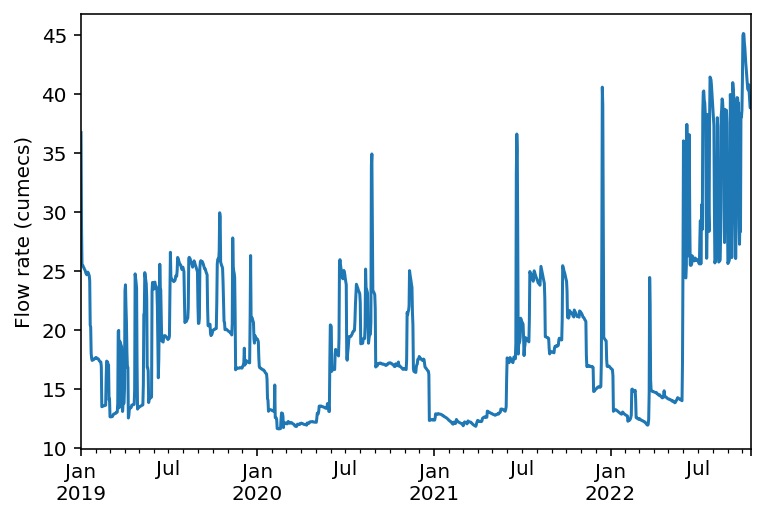

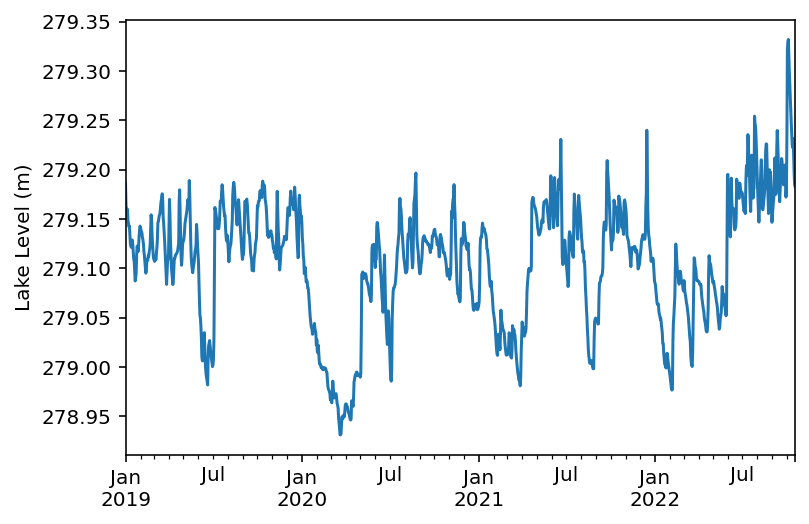

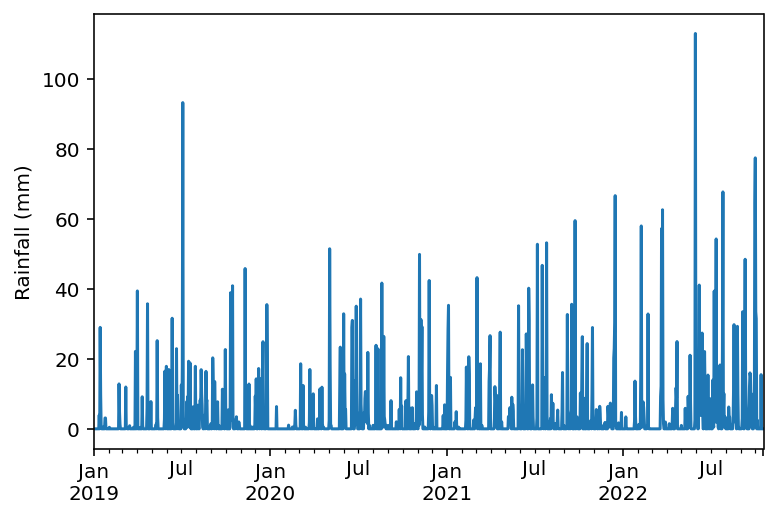

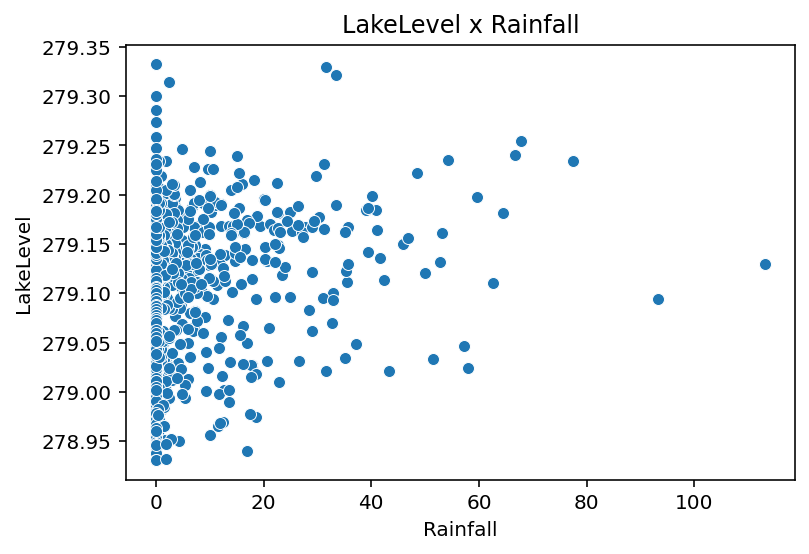

In [16]:
# Exploration of variables
#plt.figure()
#sns.lineplot(x=X_daily.index,y=X_daily["AverageGateOrdinal"])
plt.figure()
X_daily["FlowRate"].plot()
plt.ylabel("Flow rate (cumecs)")

plt.figure()
X_daily["LakeLevel"].plot()
plt.ylabel("Lake Level (m)")

plt.figure()
X_daily["Rainfall"].plot()
plt.ylabel("Rainfall (mm)")

# Investigate correlation of lake level and rainfall
plt.figure()
palette = ['tab:blue', 'tab:green', 'tab:red']
gates_to_cumecs = sns.scatterplot(
    x=X_daily["Rainfall"], 
    y=X_daily["LakeLevel"], 
    #hue=kaituna_data["Year"],
    #palette='Set1'
    )
plt.ylabel('LakeLevel')
plt.xlabel("Rainfall")
plt.title("LakeLevel x Rainfall")
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
2019-01-01,0.000000,1.000000,0.000000,1.000000
2019-01-02,0.017213,0.999852,0.034422,0.999407
2019-01-03,0.034422,0.999407,0.068802,0.997630
2019-01-04,0.051620,0.998667,0.103102,0.994671
2019-01-05,0.068802,0.997630,0.137279,0.990532


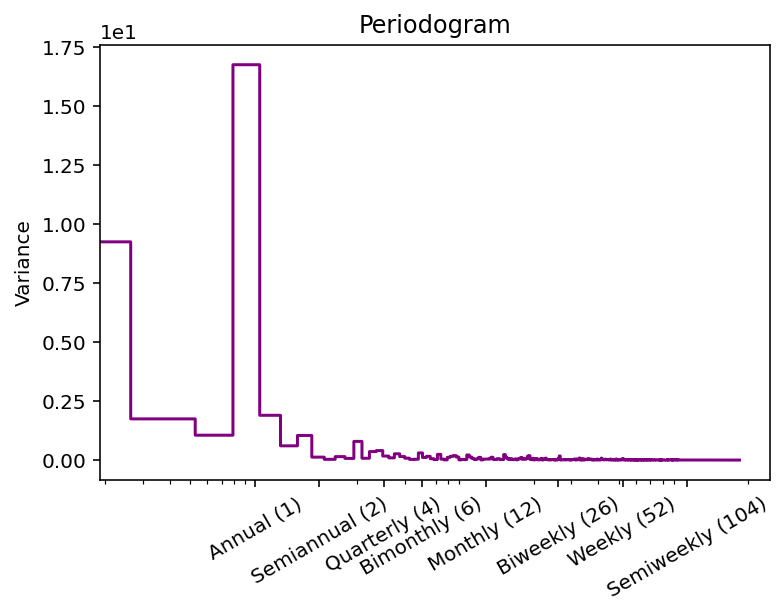

In [17]:
# Check seasonality
plot_periodogram(X_daily["FlowRate"])

# Trend feature (unused currently)
fourier = CalendarFourier(freq="A", order=2)  # 10 sin/cos pairs for "A"nnual seasonality

#Features for linear regression
dp = DeterministicProcess(
    index=X_daily.index,  # dates from the training data
    constant=False,       # dummy feature for the bias (y_intercept)
    order=0,             # the time dummy (trend)
    additional_terms = [fourier],
    drop=True,           # drop terms if necessary to avoid collinearity
)

X_seasons = dp.in_sample()
X_seasons.head()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


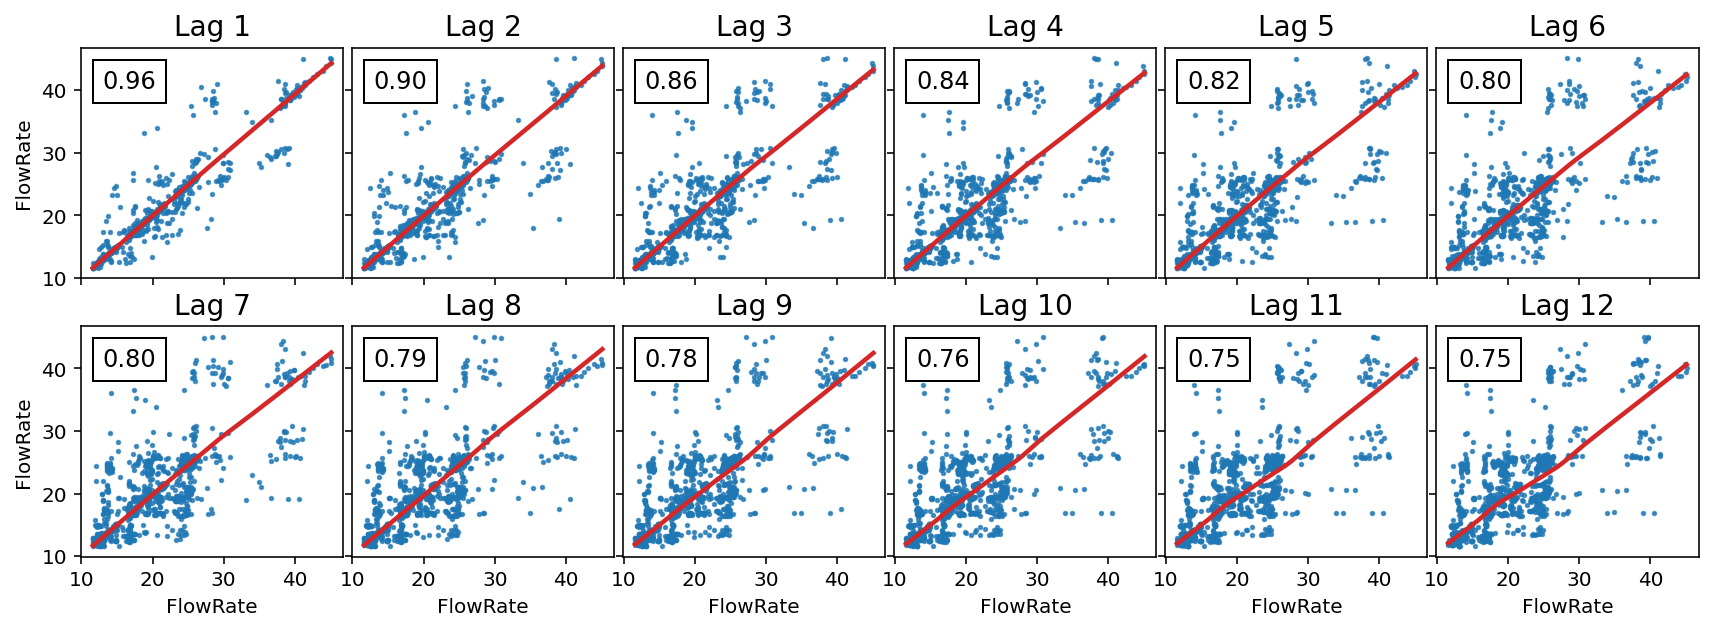

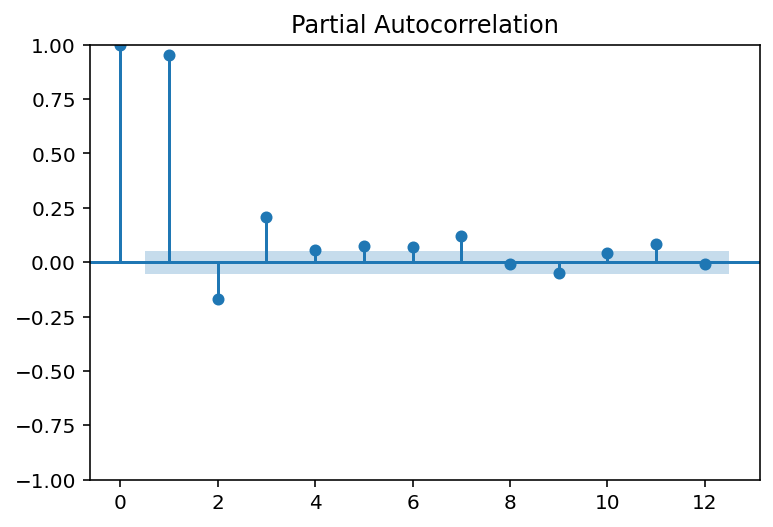

In [18]:
# Investigate if there is serial dependence
_ = plot_lags(X_daily.FlowRate, lags=12, nrows=2)
_ = plot_pacf(X_daily.FlowRate, lags=12)

#As per https://www.kaggle.com/code/ryanholbrook/time-series-as-features, let's assume >0.1 is significant correlation 

# One step forecasting

## Feature preprocessing

In [19]:
# Preprocessing Pipeline

# Days to look back
n_lags = 3

# Bundle preprocessing for data. We transform the date variables to cyclic, and make time series lags 
# for the lake level and rainfall data
preprocessor = ColumnTransformer(
    transformers=[
        #("month_sin", sin_transformer(12), ["Month"]),
        #("month_cos", cos_transformer(12), ["Month"]),
        #("weekday_sin", sin_transformer(7), ["DayOfWeek"]),
        #("weekday_cos", cos_transformer(7), ["DayOfWeek"]),
        #("hour_sin", sin_transformer(24), ["Hour"]),
        #("hour_cos", cos_transformer(24), ["Hour"]),
        ("target_lags", make_lags_transformer(n_lags), ["FlowRate"]),
        ("rainfall_lags", make_lags_transformer(n_lags), ["Rainfall"]),
        ("lakelevel_lags", make_lags_transformer(n_lags), ["LakeLevel"])
    ],
)

In [20]:
X_preprocessed = preprocessor.fit_transform(X_daily)

# Get column names
column_prefixes = [
    "FlowRate",
    "Rainfall",
    "LakeLevel"]
column_names = []
for column_prefix in column_prefixes:
    temp_list = [column_prefix + "_lag_{}".format(i) for i in range(1,n_lags + 1)]
    column_names.extend(temp_list)

# Create data frame
X_residuals = pd.DataFrame(X_preprocessed, columns=column_names, index=X_daily.index)

display(X_residuals.head())
display(X_residuals.tail())

,FlowRate_lag_1,FlowRate_lag_2,FlowRate_lag_3,Rainfall_lag_1,Rainfall_lag_2,Rainfall_lag_3,LakeLevel_lag_1,LakeLevel_lag_2,LakeLevel_lag_3
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,36.705079,NaN,NaN,0.0,NaN,NaN,279.185500,NaN,NaN
2019-01-03,28.952682,36.705079,NaN,0.0,0.0,NaN,279.164083,279.185500,NaN
2019-01-04,25.516551,28.952682,36.705079,0.0,0.0,0.0,279.158583,279.164083,279.185500
2019-01-05,25.482078,25.516551,28.952682,0.0,0.0,0.0,279.156375,279.158583,279.164083


,FlowRate_lag_1,FlowRate_lag_2,FlowRate_lag_3,Rainfall_lag_1,Rainfall_lag_2,Rainfall_lag_3,LakeLevel_lag_1,LakeLevel_lag_2,LakeLevel_lag_3
2022-10-14,40.317649,40.502736,40.908080,15.5,0.0,0.0,279.222333,279.224667,279.235875
2022-10-15,40.770953,40.317649,40.502736,0.0,15.5,0.0,279.231292,279.222333,279.224667
2022-10-16,40.090769,40.770953,40.317649,0.0,0.0,15.5,279.214250,279.231292,279.222333
2022-10-17,39.395185,40.090769,40.770953,0.0,0.0,0.0,279.195833,279.214250,279.231292
2022-10-18,38.812008,39.395185,40.090769,0.0,0.0,0.0,279.184667,279.195833,279.214250


In [21]:
# Create multi-step output for a 3 day forecast
target_column="FlowRate"
y = pd.DataFrame(X_daily[target_column])
#y = make_multistep_target(y,3).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.

# Handle missing values. #todo: make this better
X_residuals = X_residuals.dropna()

X_residuals.head()

X_seasons, X_residuals = X_seasons.align(X_residuals, join='inner', axis=0)

y, X_residuals = y.align(X_residuals, join='inner', axis=0)

In [22]:
#Test train split
#X_train, X_valid, y_train, y_valid = train_test_split(X_residuals, y, test_size=0.25, shuffle=False)

# Test train split for hybrid model fitting
X_train_seasons, X_valid_seasons, y_train, y_valid = train_test_split(X_seasons, y, test_size=0.5, shuffle=False)

X_train_residuals = X_residuals.loc[X_train_seasons.index]
X_valid_residuals = X_residuals.loc[X_valid_seasons.index]

## Model fitting

In [23]:
# Regressor model
#model = RegressorChain(XGBRegressor(random_state = 1, n_estimators = 100))
#model = RegressorChain(LinearRegression())
from sklearn.neural_network import MLPRegressor

model = BoostedHybrid(
    model_1=ElasticNet(random_state=1),
    model_2=MLPRegressor(random_state=1, max_iter=1000))

#MultiOutputRegressor

In [24]:
# Fit model
model.fit(X_train_seasons,X_train_residuals, y_train)

y_fit = pd.DataFrame(model.predict(X_train_seasons, X_train_residuals), index=X_train_residuals.index, columns=y_train.columns)
y_pred = pd.DataFrame(model.predict(X_valid_seasons, X_valid_residuals), index=X_valid_seasons.index, columns=y_valid.columns)

## Results

In [25]:
# RSME scores
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_valid, y_pred, squared=False)

print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 1.55
Test RMSE: 2.95


In [26]:
# Visualise results of multi-step output

"""
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

ax1 = X_daily.FlowRate[y_fit.index].plot(ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Flowrate (train)', 'Forecast'])

ax2 = X_daily.FlowRate[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Flowrate (test)', 'Forecast'])
"""

"\npalette = dict(palette='husl', n_colors=64)\nfig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))\n\nax1 = X_daily.FlowRate[y_fit.index].plot(ax=ax1)\nax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)\n_ = ax1.legend(['Flowrate (train)', 'Forecast'])\n\nax2 = X_daily.FlowRate[y_pred.index].plot(**plot_params, ax=ax2)\nax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)\n_ = ax2.legend(['Flowrate (test)', 'Forecast'])\n"

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


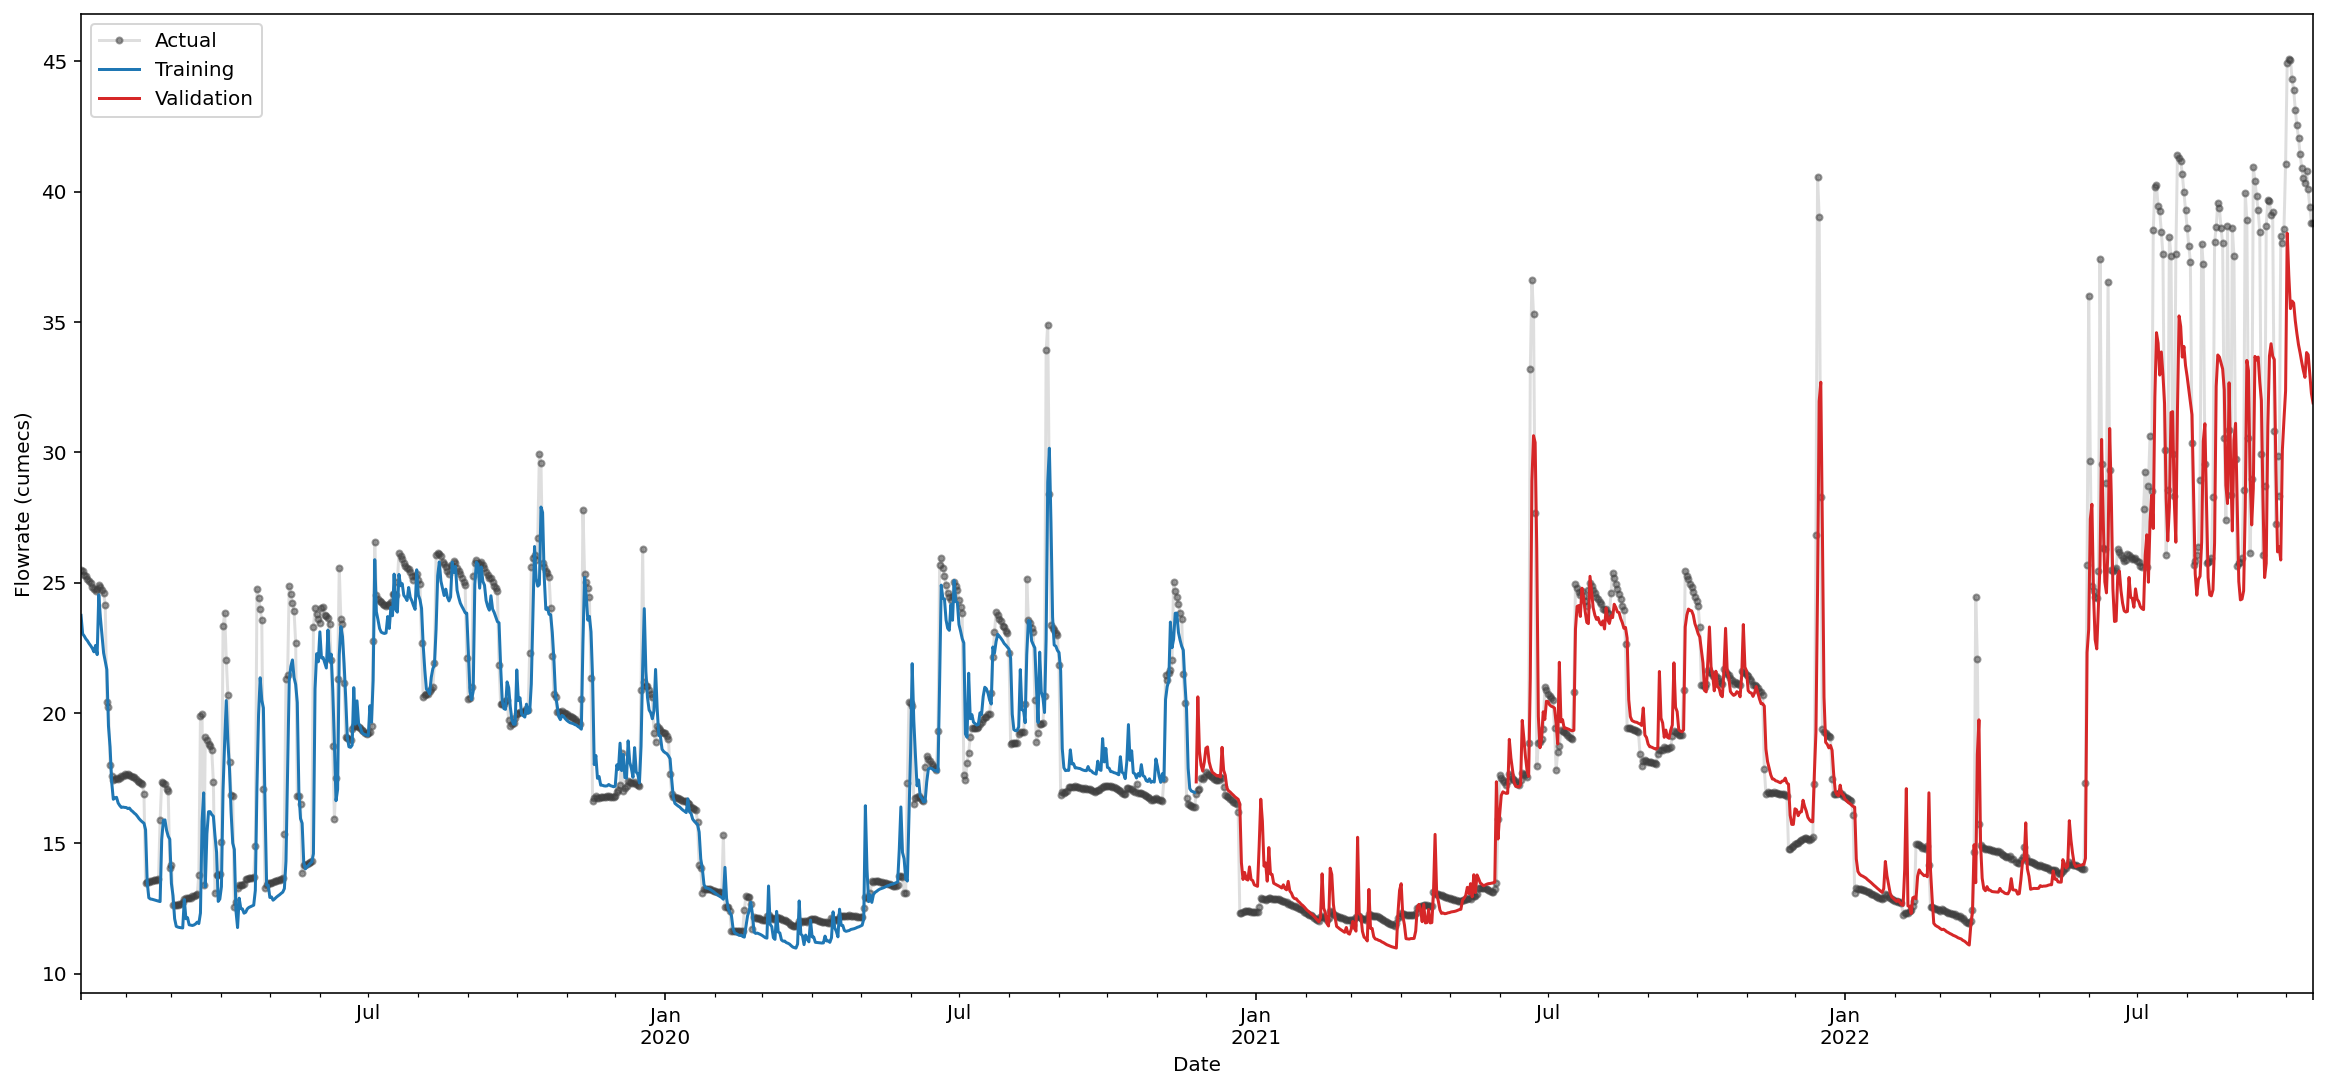

In [27]:
# Visualise hybrid model results
axs = y.loc(axis=1)[target_column].plot(
    subplots=True, sharex=True, figsize=(20, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[target_column].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[target_column].plot(subplots=True, sharex=True, color='C3', ax=axs)

plt.xlabel("Date")
plt.ylabel('Flowrate (cumecs)')
plt.legend(["Actual","Training","Validation"])

# Testing

In [28]:
"""# Test with cross-validation
#Test train split
tscv = TimeSeriesSplit()
n_splits=5
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_splits)
scores = []

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
    y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    scores.append(test_rmse)
    
    palette = dict(palette='husl', n_colors=64)

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax = y_test.plot(**plot_params, ax=ax, alpha=0.5)
    ax = plot_multistep(y_pred, ax=ax, every=20)
    _ = ax.legend(["Actual", 'Forecast'])

final_score = np.mean(scores)
print(final_score)
print(scores)
"""

'# Test with cross-validation\n#Test train split\ntscv = TimeSeriesSplit()\nn_splits=5\nTimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_splits)\nscores = []\n\nfor train_index, test_index in tscv.split(X):\n    print("TRAIN:", train_index, "TEST:", test_index)\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n\n    model.fit(X_train, y_train)\n    y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)\n    y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)\n\n    test_rmse = mean_squared_error(y_test, y_pred, squared=False)\n    scores.append(test_rmse)\n    \n    palette = dict(palette=\'husl\', n_colors=64)\n\n    fig, ax = plt.subplots(1, 1, figsize=(20, 10))\n    ax = y_test.plot(**plot_params, ax=ax, alpha=0.5)\n    ax = plot_multistep(y_pred, ax=ax, every=20)\n    _ = ax.legend(["Actual", \'Forecast\'])\n\nfinal_score = np.mean(scores)